In [74]:
import torch
from torchvision import transforms
from torchvision import models
from torchvision.models import vgg19, VGG19_Weights
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import copy

from PIL import Image
import matplotlib.pyplot as plt

In [75]:
# use cuda if it is available for GPU training otherwise it will use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# shape of the output image
imshape = (128, 128)

def image_loader(image_name):
    # scale imported image
    # transform it into a torch tensor
    loader = transforms.Compose([transforms.Resize(imshape),  transforms.ToTensor()])

    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)   # add an additional dimension for fake batch (here 1)
    return image.to(device, torch.float) # move the image tensor to the correct device

In [76]:
image_path = "../data/"
content_image_name = "content.jpeg"
style_image_name = "style.jpeg"

content_image = image_loader(image_path + content_image_name)
style_image = image_loader(image_path + style_image_name)

Content image shape : 128 x 128
Style image shape : 128 x 128


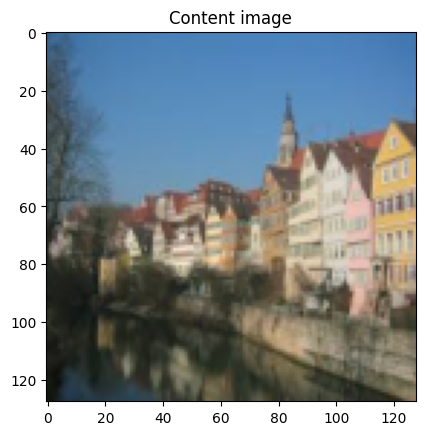

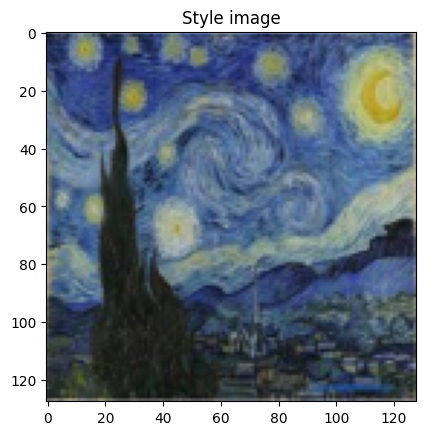

In [77]:
def image_display(tensor, title=None):
    unloader = transforms.ToPILImage()  # reconvert into PIL image
    image = tensor.cpu().clone()        # clone the tensor
    image = unloader(image.squeeze(0))  # remove the fake batch dimension
    plt.show()
    plt.imshow(image)
    if title is not None:
        plt.title(title)

content_height, content_width = content_image.shape[2], content_image.shape[3]
style_height, style_width = style_image.shape[2], style_image.shape[3]

print(f"Content image shape : {content_height} x {content_width}")
print(f"Style image shape : {style_height} x {style_width}")

image_display(content_image, "Content image")
image_display(style_image, "Style image")

<Figure size 640x480 with 0 Axes>

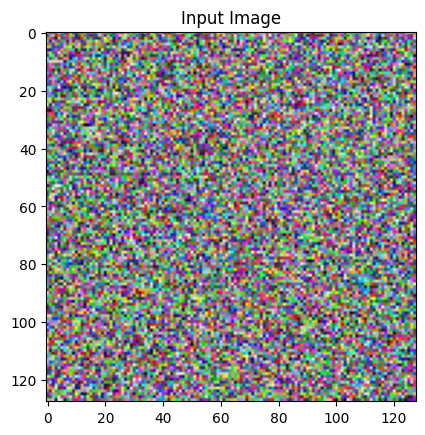

In [78]:
input_image = torch.randn(content_image.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
image_display(input_image, title='Input Image')

In [79]:
# importing the VGG 19 model with pre-trained weights
model = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1).to(device) # move the model to the correct device

In [80]:
print("Features layers :")
print(model.features)

Features layers :
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=Tr

In [81]:
print("Classification layers:")
print(model.classifier)

Classification layers:
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


***Note*** :  In our case, classification layers are not necessary, as style transfer does not require class prediction, but only the extraction of visual features.

In [82]:
model = model.features.eval() # set the model to evaluation mode

# Define the normalization parameters based on the values 
# recommended in the PyTorch VGG-19 model documentation.
model_normalization_mean = [0.485, 0.456, 0.406]
model_normalization_std = [0.229, 0.224, 0.225]

In [83]:
def get_content_loss(input, target):
    return F.mse_loss(input, target)

def gram_matrix(input):
    a, b, c, d = input.size()  
    # a = batch size, 
    # b = number of feature maps, 
    # c, d = height, width
    features = input.view(a * b, c * d)   # flatten the feature maps
    G = torch.mm(features, features.t())  # compute the dot product of the feature maps
    return G.div(a * b * c * d)           # normalize the Gram matrix

def get_style_loss(input, target):
    G_input = gram_matrix(input)
    G_target = gram_matrix(target)
    return F.mse_loss(G_input, G_target)

***Note*** : We need to implement the loss functions as custom layers in the neural network model. It allows for easy incorporation into an nn.Sequential model.

In [84]:
# We use the Pytorch module made by Alexis Jacq
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = get_content_loss(input, self.target)
        return input

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = target_feature.detach()

    def forward(self, input):
        self.loss = get_style_loss(input, self.target)
        return input

In [85]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [86]:
class Normalization(nn.Module):
	def __init__(self, mean, std):
		super(Normalization, self).__init__()
        # set mean and std as tensors, reshaped to match image dimensions
		self.mean = torch.tensor(mean).view(-1, 1, 1)
		self.std = torch.tensor(std).view(-1, 1, 1)

    # Forward method to normalize input image
	def forward(self, img):
		return (img - self.mean) / self.std

In [87]:
# Copy our model to iterate on the layers after
vgg = copy.deepcopy(model)

# Create a normalization layer with specified mean and std
normalization = Normalization(model_normalization_mean, model_normalization_std).to(device)
# Add the layer to our model
model = nn.Sequential(normalization)

In [88]:


content_losses = []
style_losses = []

i = 0

for layer in vgg.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)


    if name in content_layers_default:
        # add content loss:
        target = model(content_image).detach()
        content_loss = ContentLoss(target)
        model.add_module("content_loss_{}".format(i), content_loss)
        content_losses.append(content_loss)

    if name in style_layers_default:
        # add style loss:
        target_feature = model(style_image).detach()
        style_loss = StyleLoss(target_feature)
        model.add_module("style_loss_{}".format(i), style_loss)
        style_losses.append(style_loss)

In [89]:
for name, layer in model.named_children():
    print(name, layer)

0 Normalization()
conv_1 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
style_loss_1 StyleLoss()
relu_1 ReLU()
conv_2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
style_loss_2 StyleLoss()
relu_2 ReLU()
pool_2 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
conv_3 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
style_loss_3 StyleLoss()
relu_3 ReLU()
conv_4 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
content_loss_4 ContentLoss()
style_loss_4 StyleLoss()
relu_4 ReLU()
pool_4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
conv_5 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
style_loss_5 StyleLoss()
relu_5 ReLU()
conv_6 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu_6 ReLU()
conv_7 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu_7 ReLU()
conv_8 Conv2d(256, 256, kernel_size=(3, 3), str

***Note*** : we only need the layers from the model that are required for computing the content and style losses. Let's just keep them. 

In [90]:
# Since the last layer is a loss function, we iterate from the end of the model
# and stop when we encounter the first content or style loss layer.
for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
model = model[:i + 1]

In [91]:
for name, layer in model.named_children():
    print(name, layer)

0 Normalization()
conv_1 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
style_loss_1 StyleLoss()
relu_1 ReLU()
conv_2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
style_loss_2 StyleLoss()
relu_2 ReLU()
pool_2 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
conv_3 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
style_loss_3 StyleLoss()
relu_3 ReLU()
conv_4 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
content_loss_4 ContentLoss()
style_loss_4 StyleLoss()
relu_4 ReLU()
pool_4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
conv_5 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
style_loss_5 StyleLoss()


Let's define alpha (style weight) and beta (content weight) as below : 

$$\mathcal{L}_{\text{total}} = \alpha \mathcal{L}_{\text{content}} + \beta \mathcal{L}_{\text{style}}$$


In [92]:
style_weight = 1000000
content_weight = 1

In [93]:
# as in the thesis, we choose L-BFGS for the optimization
optimizer = optim.LBFGS([input_image.requires_grad_()])

In [96]:
num_steps = 3000

step_counter = [0]
while step_counter[0] <= num_steps:

    # Recall function for the optimiser
    def closure():

        optimizer.zero_grad()     # do not accumulate parameter gradients
        model(input_image)        # passes the image as input to the model
        style_score = 0
        content_score = 0

        # add up the losses for each style layer
        for style_loss in style_losses:
            style_score += style_loss.loss

        # add up the losses for each content layer
        for content_loss in content_losses:
            content_score += content_loss.loss

        # apply the weights
        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score # calculate the total loss
        loss.backward()                    # backward to calculate the gradients of the input image

        step_counter[0] += 1

        if step_counter[0] % 50 == 0:      # display style and content scores every 50 steps
            print("step {}:".format(step_counter[0]))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
            print()

        return style_score + content_score

    optimizer.step(closure)

input_image.data.clamp_(0, 1)


step 50:
Style Loss : 2.103240 Content Loss: 10.176758

step 100:
Style Loss : 2.102794 Content Loss: 10.173849

step 150:
Style Loss : 2.101572 Content Loss: 10.171674

step 200:
Style Loss : 2.100057 Content Loss: 10.169848

step 250:
Style Loss : 2.098897 Content Loss: 10.168076

step 300:
Style Loss : 2.098425 Content Loss: 10.165959

step 350:
Style Loss : 2.097591 Content Loss: 10.163959

step 400:
Style Loss : 2.096471 Content Loss: 10.162080

step 450:
Style Loss : 2.096163 Content Loss: 10.159839

step 500:
Style Loss : 2.095893 Content Loss: 10.157555

step 550:
Style Loss : 2.094793 Content Loss: 10.156165

step 600:
Style Loss : 2.093775 Content Loss: 10.154741

step 650:
Style Loss : 2.093178 Content Loss: 10.153069

step 700:
Style Loss : 2.092403 Content Loss: 10.151854

step 750:
Style Loss : 2.091944 Content Loss: 10.150433

step 800:
Style Loss : 2.091581 Content Loss: 10.148811

step 850:
Style Loss : 2.091112 Content Loss: 10.147535

step 900:
Style Loss : 2.090806 

tensor([[[[1.0000, 0.3478, 0.2268,  ..., 0.4985, 0.5569, 0.6718],
          [0.1275, 0.1815, 0.2369,  ..., 0.0840, 0.1968, 0.6685],
          [0.3879, 0.0510, 0.2673,  ..., 0.2255, 0.2212, 0.4865],
          ...,
          [0.0000, 0.3077, 0.0402,  ..., 0.1644, 0.2621, 0.4795],
          [0.3260, 0.0000, 0.3440,  ..., 0.3295, 0.1607, 0.4499],
          [0.1376, 0.2428, 0.0000,  ..., 0.3278, 0.4295, 0.5599]],

         [[0.3974, 0.8203, 0.3573,  ..., 0.5259, 0.3384, 0.8272],
          [0.5305, 0.0000, 0.0373,  ..., 0.0599, 0.5772, 0.2821],
          [0.0000, 0.6528, 0.1349,  ..., 0.3524, 0.2320, 0.8210],
          ...,
          [0.5848, 0.0000, 0.0818,  ..., 0.4606, 0.1735, 0.3169],
          [0.0000, 0.3431, 0.0000,  ..., 0.0714, 0.4771, 0.1641],
          [0.2525, 0.1306, 0.4148,  ..., 0.6295, 0.1378, 0.6414]],

         [[0.3930, 0.4942, 0.6156,  ..., 0.5966, 0.9087, 0.6446],
          [0.2065, 0.7985, 0.5179,  ..., 0.3370, 0.1551, 0.7838],
          [0.3308, 0.0000, 0.5760,  ..., 0

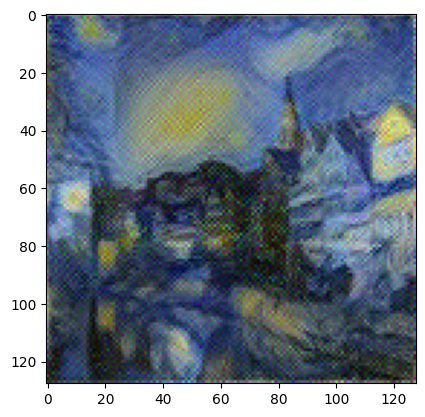

In [97]:
image_display(input_image)